## 1. Get ASSUME Running

This chapter walks you through setting up the ASSUME framework in your environment and preparing the required input files. At the end, you will confirm that the installation was successful and ready for use.


### 1.1 Installation

In [2]:
# Only run this cell if you are using Google Colab
import importlib.util

IN_COLAB = importlib.util.find_spec("google.colab") is not None

if IN_COLAB:
    %pip install assume-framework

> **Note**: After installation, **Colab may prompt you to restart the session** due to dependency changes.
> To do so, click **"Runtime" → "Restart session..."** in the menu bar, then re-run the cells above.


#### On Your Local Machine

To install ASSUME with all learning-related dependencies, run the following in your terminal:

```bash
pip install 'assume-framework[learning]'
```

This will install the simulation framework and the packages required for RL.



### 1.2 Repository Setup

To access predefined simulation scenarios, clone the ASSUME repository (Colab only):

In [3]:
# Only run this cell if you are using Google Colab
if IN_COLAB:
    !git clone --depth=1 https://github.com/assume-framework/assume.git assume-repo

> Local users may skip this step if input files are already available in the project directory.


### 1.3 Input Path Configuration

We define the path to input files depending on whether you're in Colab or working locally. This variable will be used to load configuration and scenario files throughout the tutorial.

In [4]:
colab_inputs_path = "assume-repo/examples/inputs"
local_inputs_path = "../inputs"

inputs_path = colab_inputs_path if IN_COLAB else local_inputs_path

### 1.4 Installation Check

Use the following cell to ensure the installation was successful and that essential components are available. This test ensures that the simulation engine and RL strategy base class are accessible before continuing.

In [5]:
import os, sys
sys.path.append(os.path.abspath("../../"))

try:
    from assume import World
    from assume.strategies.learning_strategies import BaseLearningStrategy

    print("✅ ASSUME framework is installed and functional.")

except ImportError as e:
    print("❌ Failed to import essential components:", e)
    print(
        "Please review the installation instructions and ensure all dependencies are installed."
    )

✅ ASSUME framework is installed and functional.


### 1.5 Limitations in Colab

Colab does not support Docker, so dashboard visualizations included in some ASSUME workflows will not be available. However, simulation runs and RL training can still be fully executed.

* In **Colab**: Training and basic plotting are supported.
* In **Local environments with Docker**: Full access, including dashboards.


### 1.6 Core Imports

In this section, we import the core modules that will be used throughout the tutorial. Each import is explained to clarify its role.

# 2. Simulation

# Testing Cournot strategy

In [ ]:
import os, sys
sys.path.append(os.path.abspath("../../"))
from assume import World
from assume.scenario.loader_csv import load_scenario_folder, run_learning
from assume.strategies.portfolio_strategies import CournotStrategy
from assume.strategies.naive_strategies import NaiveSingleBidStrategy
%load_ext autoreload
%autoreload 2

inputs_path = "../inputs"
db_uri = "sqlite:///../local_db/assume_db.db"

world = World(database_uri=db_uri, export_csv_path=f"outputs/12_market_power")
load_scenario_folder(
    world,
    inputs_path=inputs_path,
    scenario="example_01i",
    study_case=False,
)

if world.learning_config.get("learning_mode", False):
    run_learning(world)

# # 5. Execute final evaluation run (no exploration)
#



INFO:assume.world:Connected to the database
INFO:assume.scenario.loader_csv:Input files path: ../inputs/example_01i
INFO:assume.scenario.loader_csv:Study case: False
INFO:assume.scenario.loader_csv:Simulation ID: example_01i_base
INFO:assume.scenario.loader_csv:storage_units not found. Returning None
INFO:assume.scenario.loader_csv:industrial_dsm_units not found. Returning None
INFO:assume.scenario.loader_csv:residential_dsm_units not found. Returning None
INFO:assume.scenario.loader_csv:forecasts_df not found. Returning None
INFO:assume.scenario.loader_csv:Downsampling demand_df successful.
INFO:assume.scenario.loader_csv:Downsampling exchanges_df successful.
INFO:assume.scenario.loader_csv:availability_df not found. Returning None
INFO:assume.scenario.loader_csv:buses not found. Returning None
INFO:assume.scenario.loader_csv:lines not found. Returning None
INFO:assume.scenario.loader_csv:save_frequency_hours is disabled due to CSV export being enabled. Data will be stored in the CSV 

Training Episode 1 2019-01-31 00:00:00: : 2592001.0it [01:49, 23760.78it/s]                           
Training Episode 2 2019-01-31 00:00:00: : 2592001.0it [00:34, 75830.70it/s]                            
Training Episode 3 2019-01-31 00:00:00: : 2592001.0it [00:24, 105738.48it/s]
Training Episode 4 2019-01-31 00:00:00: : 2592001.0it [00:42, 61577.40it/s]
Training Episode 5 2019-01-31 00:00:00: : 2592001.0it [00:29, 88880.60it/s]                            
Training Episode 6 2019-01-31 00:00:00: : 2592001.0it [00:30, 83824.92it/s]                           
Training Episode 7 2019-01-31 00:00:00: : 2592001.0it [00:45, 56558.24it/s]
Training Episode 8 2019-01-31 00:00:00: : 2592001.0it [00:45, 57420.08it/s]
Training Episode 9 2019-01-31 00:00:00: : 2592001.0it [00:46, 55520.32it/s]


In [4]:
world.unit_operators["Operator-RL"].init_portfolio_learning()
world.run()


example_01i_base 2019-01-30 23:00:00: 100%|█████████▉| 2588401/2592000 [00:26<00:00, 98667.98it/s] 


In [ ]:
# import os, sys
# sys.path.append(os.path.abspath("../../"))
# from assume import World
# from assume.scenario.loader_csv import load_scenario_folder
# from assume.strategies.naive_strategies import NaiveSingleBidStrategy
# from assume.strategies.iterative_strategies import ErevRothStrategy
# import pandas as pd
# import matplotlib.pyplot as plt
# plt.style.use("ggplot")
# %load_ext autoreload
# %autoreload 2

# world = World(export_csv_path=f"outputs/12_market_power/erev_roth")
# load_scenario_folder(
#         world,
#         inputs_path=inputs_path,
#         scenario="example_01b",
#         study_case=False,
#     )

# for operator_id, units_operator in world.unit_operators.items():
#     for unit_id, unit in units_operator.units.items():
#         for market_id, market_strategy in unit.bidding_strategies.items():
#             if not (isinstance(market_strategy, NaiveSingleBidStrategy) 
#                 or unit_id.startswith("demand")):
#                 unit.bidding_strategies[market_id] = ErevRothStrategy(
#                     unit_id=unit_id,
#                     n_actions=10,
#                     experiment=0.001,
#                     forget=0.1,
#                     prior="normal",
#                 )
# world.run()


# strategic_bidders = ['Unit 2_1', 'Unit 1_1', 'Unit 3_1', 'Unit 4_1']
# fig, axes = plt.subplots(len(strategic_bidders), figsize=(20, 20), tight_layout=True)

# file = f"outputs/12_market_power/erev_roth/example_01b_base/market_orders.csv"
# orders = pd.read_csv(file)
# bid_price = orders.pivot_table(index="start_time", values="price", columns="bid_id")
# for i, bidder in enumerate(strategic_bidders):
#     axes[i].set_title(bidder)
#     bid_price[bidder].plot(ax=axes[i])

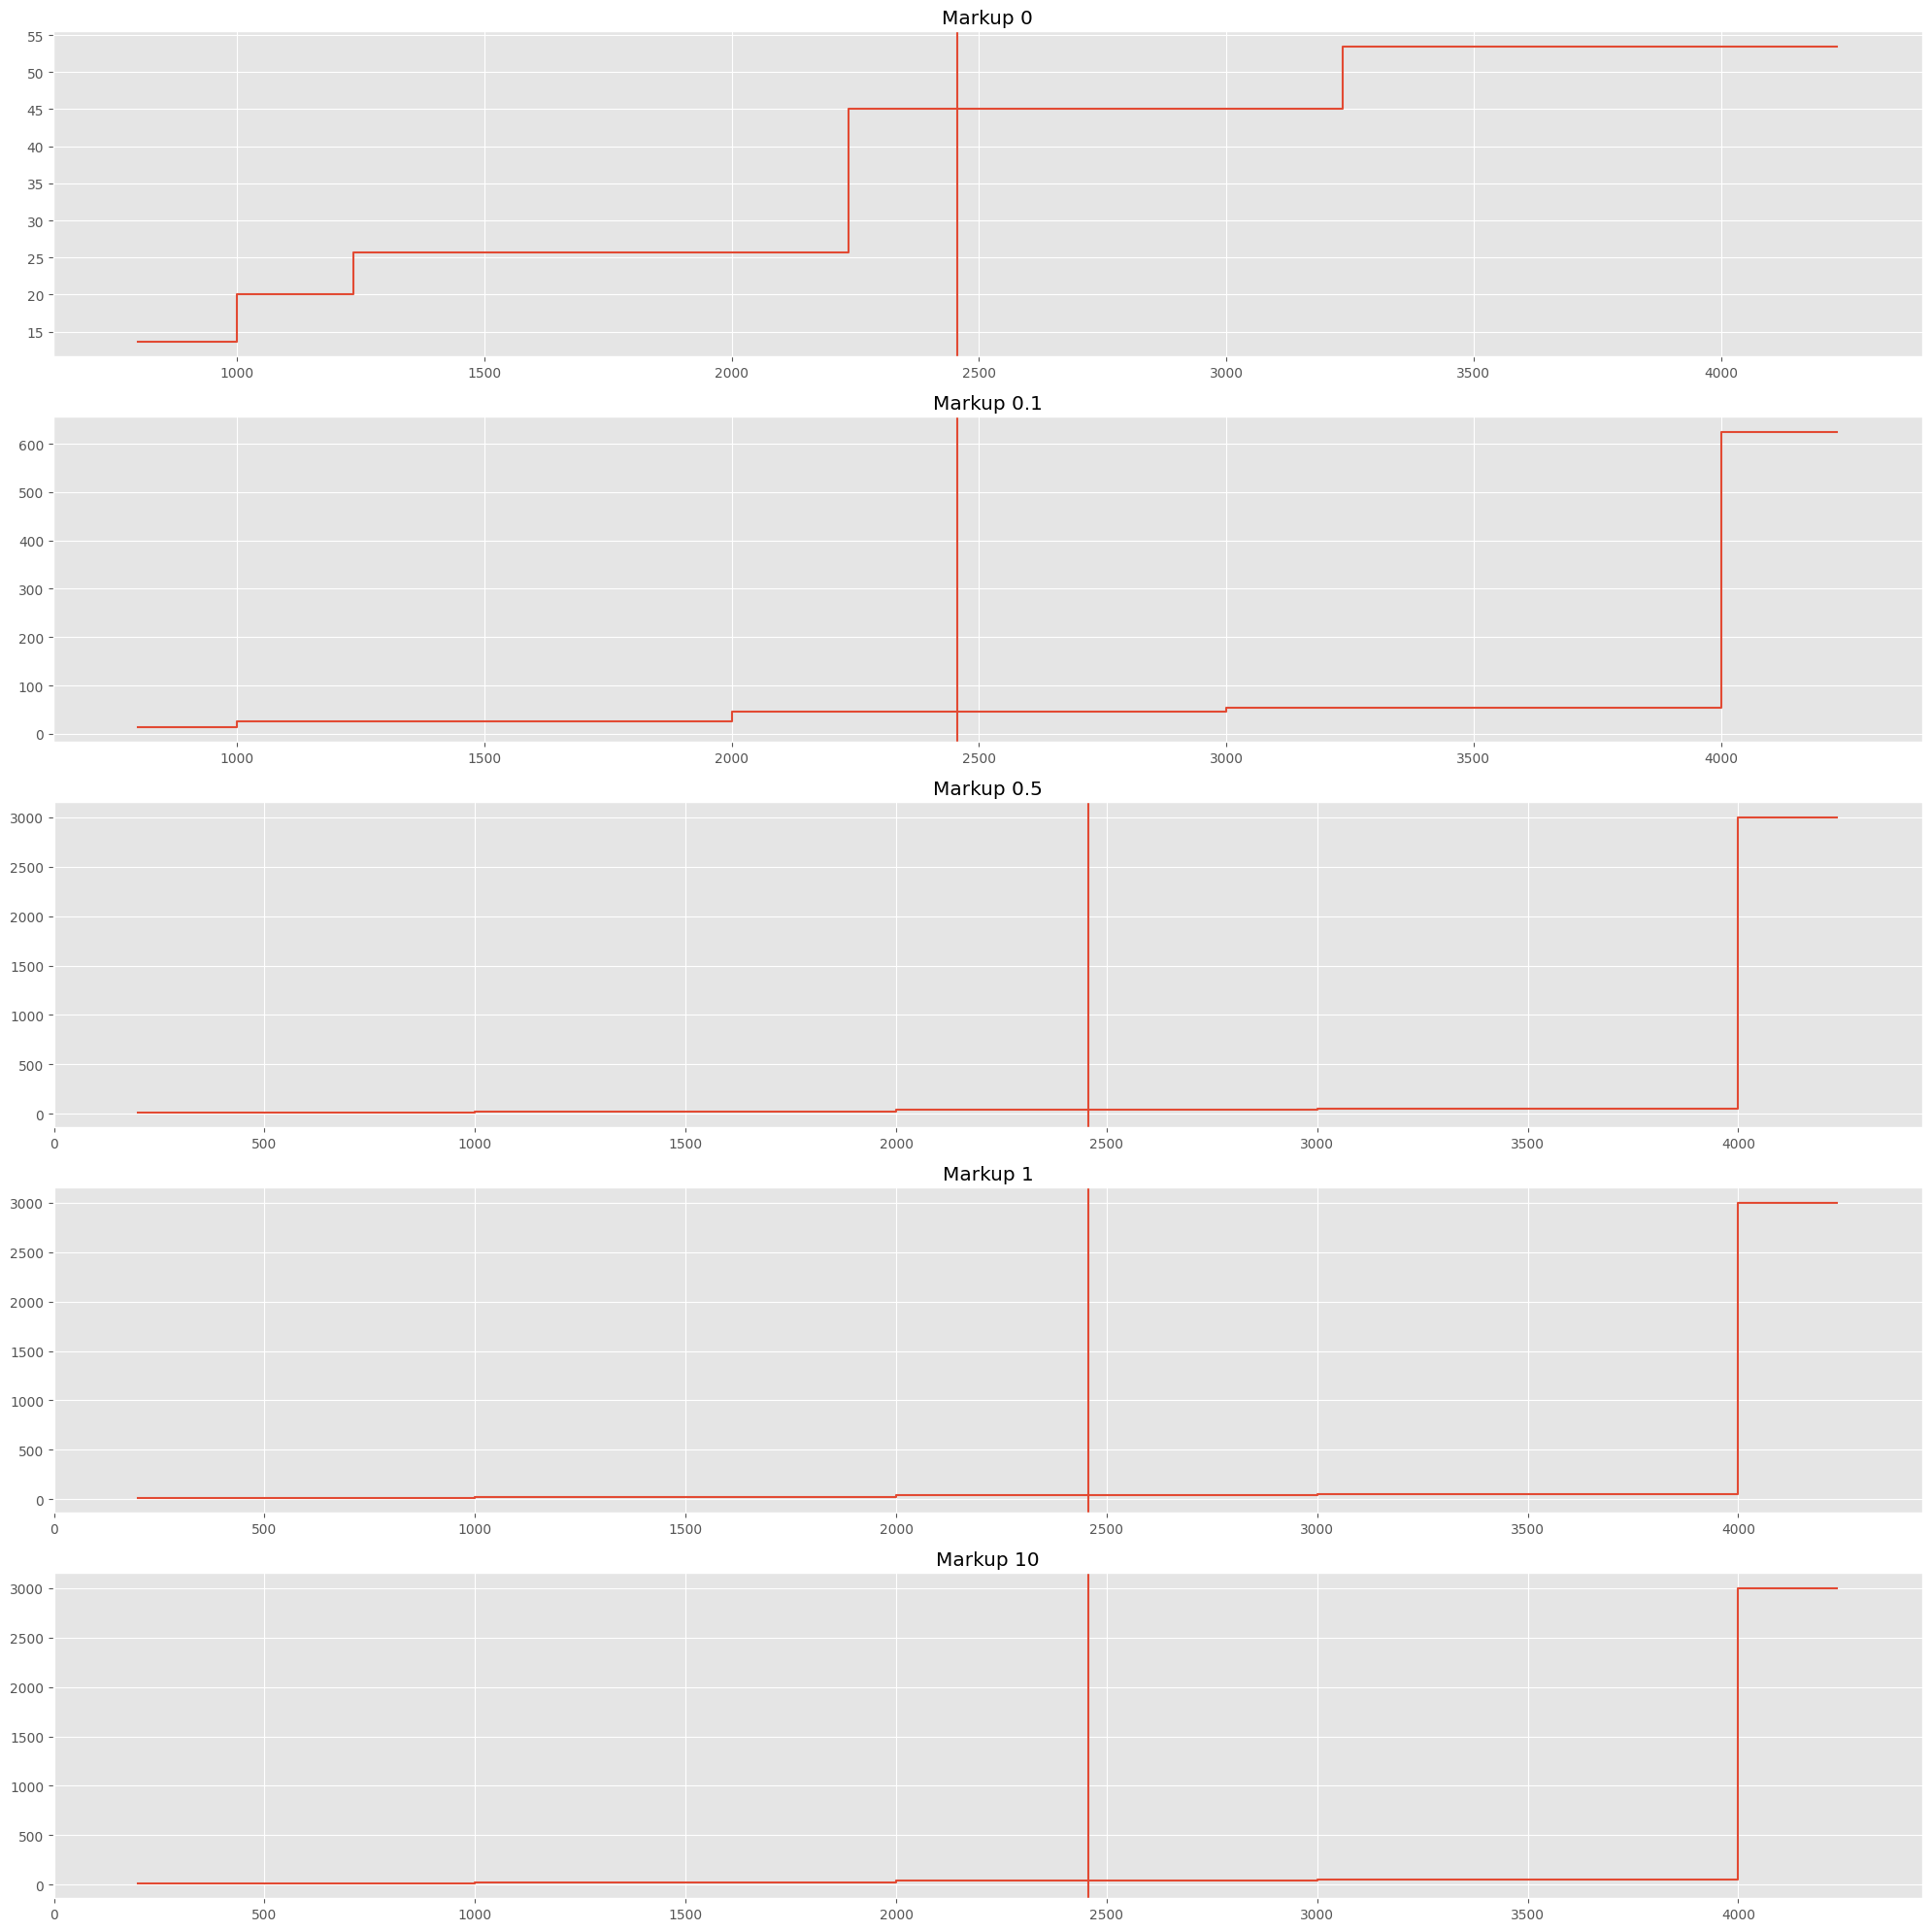

In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

fig, axes = plt.subplots(5, figsize=(20, 20), tight_layout=True)
test_hour = "2019-01-01 12:00:00"
for i, markup in enumerate([0, 0.1, 0.5, 1, 10]):
    file = f"outputs/12_market_power/markup_{markup}/example_01b_base/market_orders.csv"
    orders = pd.read_csv(file)
    # bid_price = orders.pivot_table(index="start_time", values="price", columns="bid_id")
    # bid_price.iloc[::, :-1].plot(ax=axes[i], legend=False if i !=0 else True)
    axes[i].set_title(f"Markup {markup}")
    bids = orders[orders.start_time == test_hour] 
    supply = bids[~bids.bid_id.str.startswith("demand")].sort_values(by="price")
    supply["cum_volume"] = supply["volume"].cumsum()
    demand = bids[bids.bid_id.str.startswith("demand")]
    axes[i].step(supply.cum_volume, supply.price)
    axes[i].axvline(-demand.volume.iloc[0])
